In [63]:
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import spearmanr
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from preprocessing import *
from sklearn.preprocessing import LabelEncoder

We will use this part to generate discretised featurs for the required scenarios 9, 10, 11, 12. Though for you, this part will only run scenario 10.

In [64]:
# df = pd.read_csv("data/CTU-13-Dataset/9/capture20110817.binetflow")
df = pd.read_csv("data/CTU-13-Dataset/10/capture20110818.binetflow")
# df = pd.read_csv("data/CTU-13-Dataset/11/capture20110818-2.binetflow")
# df = pd.read_csv("data/CTU-13-Dataset/12/capture20110819.binetflow")

In [65]:
df.columns

Index(['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr',
       'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes',
       'Label'],
      dtype='object')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325471 entries, 0 to 325470
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   StartTime  325471 non-null  object 
 1   Dur        325471 non-null  float64
 2   Proto      325471 non-null  object 
 3   SrcAddr    325471 non-null  object 
 4   Sport      323659 non-null  object 
 5   Dir        325471 non-null  object 
 6   DstAddr    325471 non-null  object 
 7   Dport      324634 non-null  object 
 8   State      325471 non-null  object 
 9   sTos       323412 non-null  float64
 10  dTos       297204 non-null  float64
 11  TotPkts    325471 non-null  int64  
 12  TotBytes   325471 non-null  int64  
 13  SrcBytes   325471 non-null  int64  
 14  Label      325471 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 37.2+ MB


In [67]:
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/19 10:32:31.926442,3.003373,tcp,147.32.86.194,4207,->,77.75.73.9,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
1,2011/08/19 10:37:05.849782,0.967492,tcp,147.32.3.51,1056,->,147.32.87.22,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
2,2011/08/19 10:38:48.257124,0.000000,tcp,60.2.174.102,80,?>,147.32.85.48,21885,RA_,0.0,NaN,1,60,60,flow=Background
3,2011/08/19 10:41:12.342795,1.391385,tcp,200.99.228.67,3259,->,147.32.87.62,10401,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/19 10:44:52.276736,1.124664,tcp,147.32.3.51,1089,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


## Encode Labels and Drop Background Flows

- normal = 0
- botnet = 1
- background = 2

In [68]:
df_encoded = encode_labels(df)

The counts of the flows match what is given on the website

In [69]:
df_encoded["Label"].value_counts()

2    315675
0      7628
1      2168
Name: Label, dtype: int64

In [70]:
df.isna().sum()

StartTime        0
Dur              0
Proto            0
SrcAddr          0
Sport         1812
Dir              0
DstAddr          0
Dport          837
State            0
sTos          2059
dTos         28267
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

### Encode features

In [71]:
import pickle

df_encoded.loc[df_encoded["Sport"].isna(), "Sport"] = "UNK"
sport_enc = LabelEncoder()
df_encoded.loc[:, "Sport"] = sport_enc.fit_transform(df_encoded["Sport"])

df_encoded.loc[df_encoded["Dport"].isna(), "Dport"] = "UNK"
dport_enc = LabelEncoder()
df_encoded.loc[:, "Dport"] = dport_enc.fit_transform(df_encoded["Dport"])

df_encoded.loc[df_encoded["State"].isna(), "State"] = "UNK"
state_enc = LabelEncoder()
df_encoded.loc[:, "State"] = state_enc.fit_transform(df_encoded["State"])

df_encoded.loc[df_encoded["sTos"].isna(), "sTos"] = -999
stos_enc = LabelEncoder()
df_encoded.loc[:, "sTos"] = stos_enc.fit_transform(df_encoded["sTos"])

df_encoded.loc[df_encoded["dTos"].isna(), "dTos"] = -999
dtos_enc = LabelEncoder()
df_encoded.loc[:, "dTos"] = dtos_enc.fit_transform(df_encoded["dTos"])

proto_enc = LabelEncoder()
df_encoded.loc[:, "Proto"] = proto_enc.fit_transform(df_encoded["Proto"])

dir_enc = LabelEncoder()
df_encoded.loc[:, "Dir"] = dir_enc.fit_transform(df_encoded["Dir"])

srcaddr_enc = LabelEncoder()
df_encoded.loc[:, "SrcAddr"] = srcaddr_enc.fit_transform(df_encoded["SrcAddr"])
pickle.dump(srcaddr_enc, open('./data/utils/SrcAddr_LabelEncoder.pkl', 'wb'))

dstaddr_enc = LabelEncoder()
df_encoded.loc[:, "DstAddr"] = dstaddr_enc.fit_transform(df_encoded["DstAddr"])
pickle.dump(dstaddr_enc, open('./data/utils/DstAddr_LabelEncoder.pkl', 'wb'))

In [72]:
df_filtered = drop_background_flows(df_encoded)

In [73]:
df_filtered["Label"].value_counts()

0    7628
1    2168
Name: Label, dtype: int64

## Find correlations between features and label

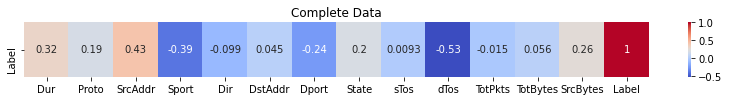

In [74]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(14, 1))
sns.heatmap(df_filtered.corr("spearman").loc[['Label']],cmap = 'coolwarm', annot=True)
ax1.set_title('Complete Data')
plt.show()


# f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 8))

# sns.heatmap(df_filtered[df_filtered["Label"] == 1].corr("spearman"), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
# ax1.set_title('Malicious')

# sns.heatmap(df_filtered[df_filtered["Label"] == 0].corr("spearman"), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
# ax2.set_title('Normal')

# plt.show()

In [75]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["TotBytes"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.056
Samples are correlated (reject H0) p=0.000


In [76]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["Dur"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.320
Samples are correlated (reject H0) p=0.000


## 3. Find the optimal number of bins for discretization

- Use kmeans for discretization
- Use the elbow method by plotting the within cluster sum of squares vs number of clusters
- Use cluster labels as the discretized values
- Sort the clusters according to the ordinal rank of the feature

In [77]:
def visualize_discretization(feature, min_k=2, max_k=15):
    distortions = {}
    kmeans_models = {}
    for k in tqdm(range(min_k, max_k)):
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(feature)
        kmeans_models[k] = kmeans_model
        distortions[k] = kmeans_model.inertia_

    plt.figure(figsize=(16,8))
    plt.plot(range(min_k, max_k), list(distortions.values()), 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    return kmeans_models, distortions

In [78]:
df_filtered["sTos"].value_counts()

1    9793
0       3
Name: sTos, dtype: int64

## Numerically Encode Dir and Proto features

### 1.1 Discretization of TotBytes

In [79]:
df_filtered, dir_enc = encode(df_filtered, "Dir")
df_filtered, protocol_enc = encode(df_filtered, "Proto")

100%|██████████| 13/13 [00:01<00:00, 12.48it/s]


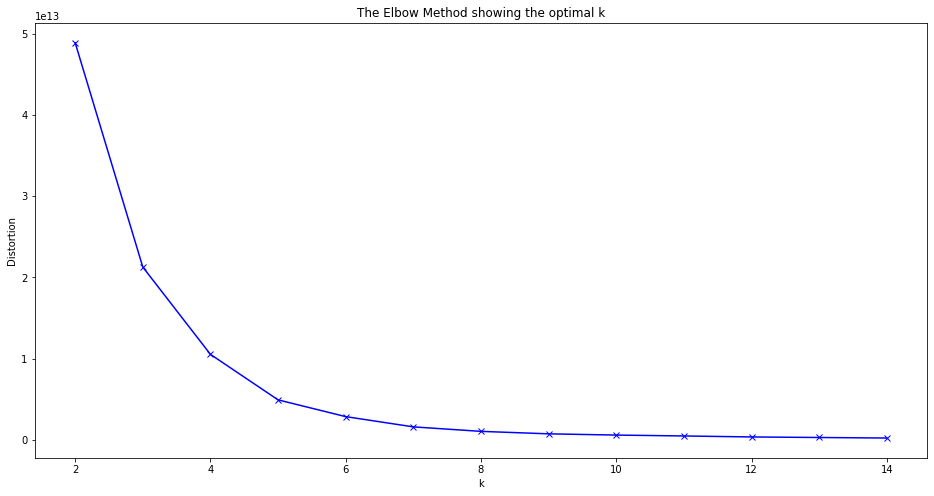

In [80]:
tot_bytes = df_filtered["TotBytes"].to_numpy().reshape(-1, 1)
kmeans_models, distortions = visualize_discretization(tot_bytes)

Choosing k = 5

In [81]:
# discretize
df_filtered.loc[:, "TotBytes_"] = kmeans_models[4].predict(tot_bytes)

In [82]:
df_filtered.TotBytes_.value_counts()

0    9689
3      98
2       6
1       3
Name: TotBytes_, dtype: int64

### 1.2 Discretization of TotBytes

100%|██████████| 13/13 [00:00<00:00, 15.31it/s]


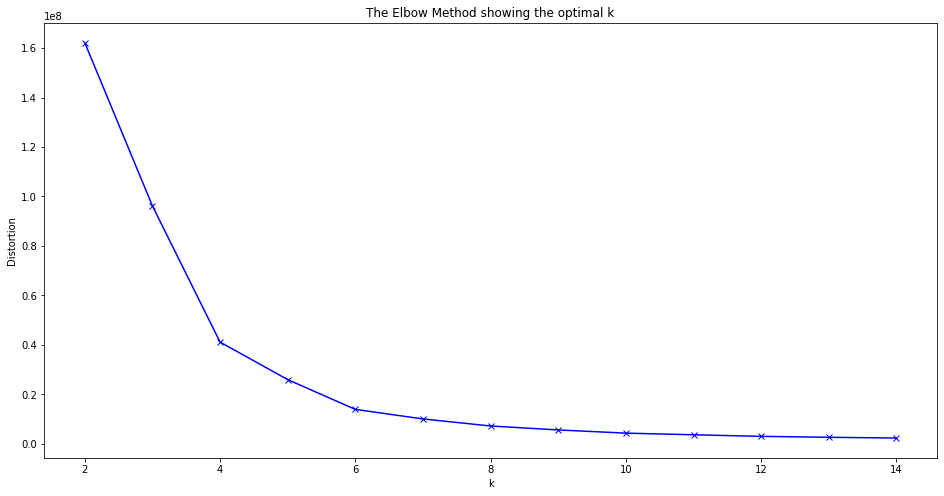

In [83]:
dur = df_filtered["Dur"].to_numpy().reshape(-1, 1)
kmeans_models, distortions = visualize_discretization(dur)

Choosing k = 5

In [84]:
# discretize
df_filtered.loc[:, "Dur_"] = kmeans_models[5].predict(dur)

In [85]:
df_filtered.Dur_.value_counts()

0    9010
3     464
2     155
4      84
1      83
Name: Dur_, dtype: int64

### 1.3 Sort the clusters according to the ordinal rank of the features

In [86]:
# ## order the total bytes discretized values according to its ordinal rank
# min_list = []
# for i in range(5):
#     min_list.append((i, df_filtered[df_filtered["TotBytes_"] == i]["TotBytes"].describe()["min"]))
# min_list = sorted(min_list, key=lambda x: x[1])

# cluster_indices = []
# for i in range(5):
#     cluster_indices.append(df_filtered["TotBytes_"] == i)

# cluster_ordinal_map = {i: c[0] for i, c in enumerate(min_list)}

# for i, c in enumerate(min_list):
#     df_filtered.loc[cluster_indices[i], "TotBytes_"] = c[0]

In [87]:
# ## order the duration discretized values according to its ordinal rank
# min_list = []
# for i in range(5):
#     min_list.append((i, df_filtered[df_filtered["Dur_"] == i]["Dur"].describe()["min"]))
# min_list = sorted(min_list, key=lambda x: x[1], reverse=True)

# cluster_indices = []
# for i in range(5):
#     cluster_indices.append(df_filtered["Dur_"] == i)

# cluster_ordinal_map = {i: c[0] for i, c in enumerate(min_list)}

# for i, c in enumerate(min_list):
#     df_filtered.loc[cluster_indices[i], "Dur_"] = c[0]

## 2. Encoding using Attributes Mapping algorithm

_Algorithm 1 from [G. Pellegrino et.al. Learning Behavioral Fingerprints From Netflows Using Timed Automata](http://dl.ifip.org/db/conf/im/im2017/036.pdf)_

We combine `TotBytes` and `Dur` using this algorithm

In [88]:
num_bins = {"TotBytes_": 4, "Dur_": 5}

In [89]:
def attribute_mapping_encode(row):
    code = 0
    features = row.index
    space_size = reduce((lambda x, y: num_bins[x] * num_bins[y]), features)
    for feature in features:
        code = code + row[feature]*space_size/num_bins[feature]
        space_size = space_size/num_bins[feature]
    return code

In [90]:
df_filtered["TotBytes_Dur"] = df_filtered[["TotBytes_", "Dur_"]].apply(attribute_mapping_encode, axis=1)

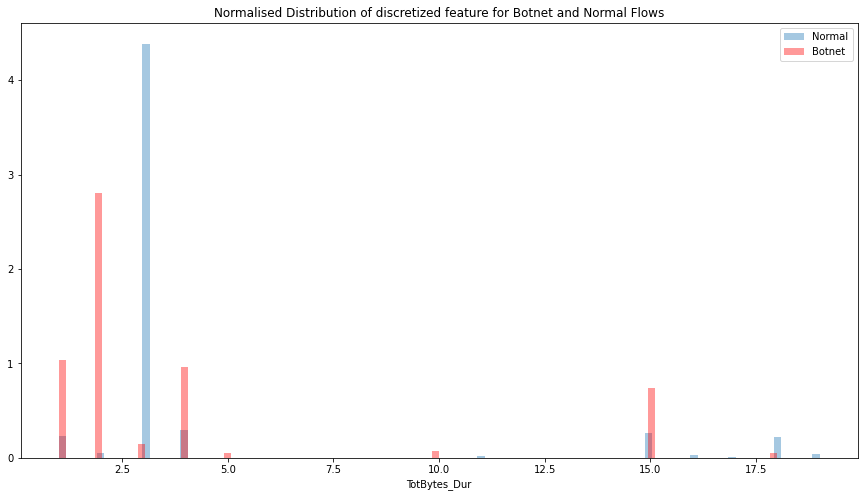

In [91]:
f, (ax1) = plt.subplots(1,1,figsize =(15, 8))

ax1.set_title("Normalised Distribution of discretized feature for Botnet and Normal Flows")
sns.distplot(df_filtered[(df_filtered["Label"] == 0)&(df_filtered["TotBytes_Dur"] > 0)]["TotBytes_Dur"], kde=False, ax=ax1, bins=100, label="Normal", norm_hist=True)
sns.distplot(df_filtered[(df_filtered["Label"] == 1)&(df_filtered["TotBytes_Dur"] > 0)]["TotBytes_Dur"], kde=False, ax=ax1, bins=100, label="Botnet", norm_hist=True, color='red')
ax1.legend()


In [92]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["TotBytes_Dur"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.101
Samples are correlated (reject H0) p=0.000


We have saved required discretisations separately under `data/utils/discretized_scenario_<scenario_number>.csv` but for you we will dump in a temporary .csv

In [93]:
df_filtered.to_csv("data/TotBytes_Dur_discretized.csv", index=False)
# df_filtered.to_csv("data/utils/discretized_scenario_12.csv", index=False)